# Data Science: Click-through rate

**Notebook by Emmanuel Contreras-Campana, PhD**

### Introduction

One of the key applications at TripleLift is a bidder designed to optimize the performance of campaigns. A big driver of this performance is the click through rate (clicks/impressions). We take a sample of company data (<a href="https://s3.amazonaws.com/ops.triplelift.net/public/code-test/data-code-test.tar.gz">data</a>) and use it to develop a model that is able to predict the click through rate.

The columns in the file are:
- **timestamp**: time of the impression
- **placement_id**: a unique identifier for a web page
- **browser_id**: unique identifier for a browser (firefox, chrome, ie10, etc)
- **os_id**: unique identifier for an os (windows, linux, osx)
- **region**: geographic region (states in the US)
- **country**: country code
- **is_adserver**: ignore this column
- **campaign**: unique identifier for a campaign (with it's own targeting parameters - for example target NY +
NJ)
- **creative_asset_id**: unique identifier for an image belonging to a campaign mouseovers: 1 if there was a mouseover
**clicks**: 1 if thee was there a click
- **max_duration**: if this was a video, how far did the viewer get video_length: if this was a video, what was the length of the video viewable: was the ad viewable

### Load Libraries

We load all the necessary python libraries that will permit us to load the data files, pre-process and clean the data, perform data validation, produce statistical summaries, conduct exploratory data analysis, as well as feature transformation, feature ranking, and feature selection. Python libraries will also be needed for model selection, evaluating overfitting, executing standard nested k-fold cross validation for hyper-parameter optimization and model evaluation. 

In [1]:
## Import common python libraries

import sys
import time
import math
import heapq
import os.path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import operator
import collections

# Import panda library
import pandas.core.common as com
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix
from pandas.core.index import Index

# Import scipy
import scipy as sp
from scipy.stats import ks_2samp

# Import itertools
import itertools
from itertools import cycle

# Import collections
from collections import defaultdict, Counter

# Import Jupyter
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display

# Import scikit-learn
import sklearn

from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   LabelEncoder, OneHotEncoder)

from sklearn import feature_selection

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif

from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve, 
                             auc, average_precision_score, precision_score, 
                             brier_score_loss, recall_score, f1_score, log_loss, 
                             classification_report, precision_recall_curve,
                             accuracy_score)

from sklearn.externals import joblib

# Import keras library
from keras.wrappers.scikit_learn import KerasClassifier

# Import imblearn
import imblearn
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Import data science toolkit
from dskit import *

# Fix random seed for reproducibility
seed = 7
random.seed(a=seed)

# Specifying which nodes should be run interactively
#InteractiveShell.ast_node_interactivity = 'all'

Using Theano backend.


Python version 2.7.13 (default, Apr  4 2017, 08:46:44) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
Numpy version 1.13.3
Pandas version 0.20.3
Matplotlib version 2.1.0
Seaborn version 0.8.0
Scipy version 0.19.1
Scikit-learn version 0.19.0
Imblance version 0.3.0
Python version 2.7.13 (default, Apr  4 2017, 08:46:44) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
Numpy version 1.13.3
Pandas version 0.20.3
Matplotlib version 2.1.0
Seaborn version 0.8.0
Scipy version 0.19.1
Scikit-learn version 0.19.0
Imblance version 0.3.0


### Load Data Files

Most data files contain approximately 1M entries. There are a total of 8 files totaling 8M data entries. We list the features and response names. We store the data in a Pandas DataFrame for greater ease of data manipulation.

**Note: To reduce running time of the program comment out some of the input files**

In [2]:
%%time
## Load data files

# Feature names
features = ['timestamp', 'placement_id', 'browser_id', 'os_id',
            'region', 'country', 'is_adserver', 'campaign', 
            'creative_asset_id', 'mouseovers', 'clicks', 'max_duration',
            'video_length', 'viewable']

# Check loading data with sc.textFile
baseDir = os.path.join('data')
inputPath = os.path.join('ctr/')
filePath = os.path.join(baseDir, inputPath)

# Load dataset
csvList = []

csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0000_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0001_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0002_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0003_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0004_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0005_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0006_part_00', 
                           header = None, delimiter = '|', names = features))
csvList.append(pd.read_csv(filepath_or_buffer=filePath+'data-0007_part_00', 
                           header = None, delimiter = '|', names = features))

df_raw_full = pd.concat(csvList)

print "Total number of events:", df_raw_full.shape[0]                 
print "Number of features:", df_raw_full.shape[1]

Total number of events: 8294824
Number of features: 14
CPU times: user 10.8 s, sys: 2.07 s, total: 12.9 s
Wall time: 13.1 s


In [3]:
%%time
## To decrease the running time even futher we reduce the number of rows 
## of the dataframe to 10k randomly sampled data entries

full = True 

df_raw = df_raw_full if full==True else df_raw_full.sample(n=200000, 
                                                           replace=False, 
                                                           random_state=seed, 
                                                           axis=None)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


### Data pre-processing and cleaning

We investigate the data for any missing values and decide if any feature should be discarded.

In [ ]:
%%time
## The following snippet of code was written by Rajashree Baradur
## https://github.com/rajashreebaradur/Kaggle_HousePrices/blob/
## master/getting_cleaning_data.ipynb

# Number of null entries
print df_raw.select_dtypes(include=['int']).isnull().sum(), "\n"
print df_raw.select_dtypes(include=['float']).isnull().sum(), "\n"
print df_raw.select_dtypes(include=['object']).isnull().sum(), "\n"

# Number of non-null entries
print "\nInformation:" 
df_raw.info()

The data is pre-processed and cleaned for any missing values. We drop the "is_adserver" column since it was asked to be ignored. The "max_duration" and "video_length" columns are dropped because there were few instances in which they had any actual values. We will retain the "region" and "country" columns because there are enough entries with actual values.

The "timestamp" column has date and time entries from 10/25/2015. Therefore, we eliminate the extraneous date information and only retain the hour, minute, and second information.

In [4]:
%%time
## Data pre-processing and cleaning (data munging)

# Drop irrelevant columns or columns with too many NaN
df_raw_selected = df_raw.drop(['is_adserver', 'max_duration', 'video_length'], 
                              axis=1, inplace=False) 

# Drop rows with at least one NaN
df_raw_selected.dropna(how='any', inplace=True)

# Convert timestamp from string to pandas timestamp
df_raw_selected['timestamp'] = df_raw_selected['timestamp'].apply(pd.Timestamp)

# Extract day of week from pandas timestamp
#df_raw_selected['day_of_week'] = \
#df_raw_selected['timestamp'].apply(lambda t: t.weekday_name)

# Extract hour from pandas timestamp
df_raw_selected['hour'] = df_raw_selected['timestamp'].apply(lambda t: t.hour)

# Remove duplicate entries from dataframe if there are any
df_raw_selected.drop_duplicates(inplace=True)

CPU times: user 51.5 s, sys: 5.63 s, total: 57.1 s
Wall time: 59.4 s


### Statistical Summary

We give a statistical summary below to make sure the data makes sense and that nothing anomolous is present. As we can see values look promising and have acceptable variances.

In [5]:
%%time
## Calculate class label cpercentages

composition = df_raw_selected.groupby(by='clicks', axis=0).count()['timestamp']

print composition/composition.sum()

clicks
0    0.995403
1    0.004597
Name: timestamp, dtype: float64
CPU times: user 1.53 s, sys: 467 ms, total: 2 s
Wall time: 2.11 s


The number of clicks in the data is about 0.46% which suggests that we are dealing with an extremely unbalanced dataset. In all likelihood, we will have to perform some class balancing our data.

In [ ]:
%%time
## Print statistical summary of dataset

# To print out all rows and columns to the terminal
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print "Head:"
display(df_raw_selected.head())

print "\nDescribe:"
display(df_raw_selected.describe())

print "Describe based on clicks or non-clicks:"
display(df_raw_selected.groupby('clicks').describe())

###  Feature Visualization: Basic Exploratory Data Analyses

We conduct a basic exploratory data analyses by depicting the relationship between **click vs no-click**, and the features. For the investigation of the click through rate we will not make use of "viewable" and "mouseovers" as these are not generally available during real-time bidding of ad impressions. We will keep "hour" but drop "timestamp".

In [ ]:
df_raw_selected.drop(['timestamp', 'viewable', 'mouseovers'], axis=1, inplace=True)

A chi-squared statistic may be used to determine if any two features are independent of one another.

In [ ]:
%%time
columns = ['placement_id', 'browser_id', 'os_id',
           'region', 'country', 'campaign', 
           'creative_asset_id', 'clicks']

plot_chi2_matrix(df_raw_selected, columns, p_value=True)

Performing a one-way ANOVA through the use of an f statistic we can determine if a numerical feature is independent of a categorical feature.

/Users/ecampana/virtualenvs/insight/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


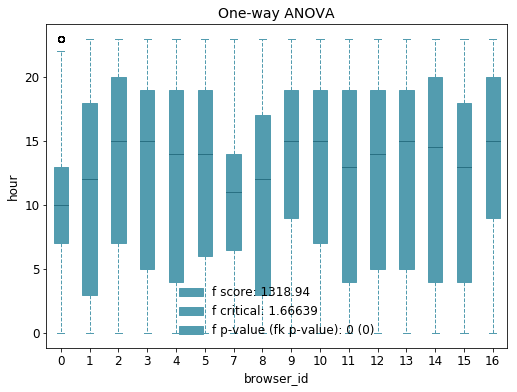

None

CPU times: user 5.48 s, sys: 2.09 s, total: 7.57 s
Wall time: 7.97 s


In [6]:
%%time

plot_f_oneway(df_raw_selected, 'browser_id', 'hour')

We now plot bar graphs to determine if there are any trends between click through rates and any of the features.

In [ ]:
%%time
## Plot bar graph of categorical features

# features
column=['placement_id', 'browser_id', 'os_id', 'region',
        'country', 'campaign', 'creative_asset_id'] # 'day_of_week'

# legend labels
label = ['no-clicks', 'clicks']

# signal and background
signal = df_raw_selected.query('clicks > 0')
background = df_raw_selected.query('clicks < 1')

# plot histograms
plot_categorical_features(signal, background, columns=column, top_n=20, 
                          normed=True, style=None, legend_label=label)

In [ ]:
%%time
## Plot hitogram of numerical features

# features
column=['hour']

# legend labels
label = ['no-clicks', 'clicks']

# signal and background
signal = df_raw_selected.query('clicks > 0')
background = df_raw_selected.query('clicks < 1')

# plot histograms
plot_numerical_features(signal, background, columns=column, 
                        bins=24, normed=True, style=None, 
                        discrete=True, legend_label=label)

### Feature Engineering

Since most machine learning algorithms cannot handle categorical (nominal) features directly we will perform **one-hot-encoding** and then droping them from the original dataframe to eliminate collinearity. We also create the features dataframe and response array which will later on be used for feature ranking and machine learning modeling.

In [ ]:
%%time
## Create features dataframe and target array

df_X = df_raw_selected.drop('clicks', axis=1, inplace=False)
df_y = df_raw_selected['clicks']

# Split data into training and test
X_train, X_test, y_train, y_test = \
       train_test_split(df_X, df_y, test_size=0.33, random_state=seed)

In [ ]:
%%time
## Label encoding

# features to label encode
columns = ['country', 'region']

# label encode
X_train, X_test = label_encoder(X_train, X_test, columns)

# drop origin "region" and "country" columns
X_train.drop(columns, axis=1, inplace=True)
X_test.drop(columns, axis=1, inplace=True)

In [ ]:
%%time
## Feature transformations of categorical (nominal) variables

# One-hot encoding
# Note: sparse=False for numpy.ndarray 
# else sparse=True for scipy.sparse.csr.csr_matrix
enc = OneHotEncoder(categorical_features='all', n_values='auto',
                    sparse=True, handle_unknown='ignore') 

# features to one-hot encode
column = ['placement_id', 'browser_id', 'os_id', 'region_le', 
          'country_le', 'campaign', 'creative_asset_id']
# column = ['placement_id', 'browser_id', 'os_id', 
#            'country_le', 'campaign', 'creative_asset_id']


enc.fit(X_train[column])

X_train = enc.transform(X_train[column])
X_test = enc.transform(X_test[column])

We may want to consider **undersampling** of the dataset at this time to reduce the extreme imbalance in class labels. Due to a lack of time currently this will have to be investigated further at a later date.

## Machine Learning Algorithms for Model Building

### Performance of Predictive Modeling Candidates

We investigate several machine learning models in order to establish which algorithm may be the most promising for the predicitve modeling of click through rates. A few performance measurements wil be used to help select our model, namely, **accuracy**, **log loss**, and the **area under the receiver operating characteristic (ROC) curve (AUC)**.

We estiblish our **baseline model** that we use to compare all other candidated models against.

In [ ]:
%%time
## Fitting a dummy model (baseline model)
# 'most_frequent', 'stratified'
dc = DummyClassifier(strategy='stratified', random_state=seed) 
dc.fit(X_train, y_train)

# persist model
joblib.dump(dc, 'models/DummyClassifier.pkl')

# Dummy classifier probability predictions
dc_predict_proba = dc.predict_proba(X_test)[:, 1]

# Evaluate model performance with accuracy (i.e. Brier score)
# note: original label composition was 0.996013
score = 1 - brier_score_loss(y_test, dc_predict_proba)

print "baseline (Brier score):", score

We consider **Logistic Regression** as our first candidate predictive model.

In [ ]:
%%time
## Fitting a logistic regression model with ridge regression
log = LogisticRegression(penalty='l2', C=1, random_state=seed)
log.fit(X_train, y_train)

# persist model
joblib.dump(log, 'models/LogisticRegression.pkl')

# Logistic regression classifier probability predictions
log_predict_proba = log.predict_proba(X_test)[:, 1]

# Evaluate model performance with accuracy (i.e. Brier score)
score = 1 - brier_score_loss(y_test, log_predict_proba)

print "model (Brier score):", score

In [ ]:
%%time

# Evaluate model performance with log loss
print "baseline (log loss): ", log_loss(y_test, dc.predict_proba(X_test))
print "model (log loss): ", log_loss(y_test, log.predict_proba(X_test))

The logistic regression model performs an order of magnitude better than the baseline model using this alternative performance metric.

Yet another possible candidate model we can investigate are a **Random Forest**, **Gradient Boosted Decision Trees**, **Decision Trees** classifier.

In [ ]:
%%time
## Fitting a random forest model
rf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=10)
rf.fit(X_train, y_train)

# persist model
joblib.dump(rf, 'models/RandomForestClassifier.pkl')

# Evaluate model performance with log loss
score = log_loss(y_test, rf.predict_proba(X_test))

print "model (log loss): ", score

In [ ]:
%%time
## Fitting a gradient boosted model
gt = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_leaf=10)
gt.fit(X_train, y_train)

# persist model
joblib.dump(gt, 'models/GradientBoostingClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, gt.predict_proba(X_test))

print "model (log loss): ", score

In [ ]:
%%time
## Fitting a decision tree model
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
dt.fit(X_train, y_train)

# persist model
joblib.dump(dt, 'models/DecisionTreeClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, dt.predict_proba(X_test))

print "model (log loss): ", score

In [ ]:
%%time
## Fitting an adaptive boosted model
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)

# persist model
joblib.dump(ab, 'models/AdaBoostClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, ab.predict_proba(X_test))

print "model (log loss): ", score

In [ ]:
%%time
## Fitting a bagging model
bg = BaggingClassifier(n_estimators=100)
bg.fit(X_train, y_train)

# persist model
joblib.dump(bg, 'models/BaggingClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, bg.predict_proba(X_test))

print "model (log loss): ", score

In [ ]:
%%time
## Fitting a extra trees model
et = ExtraTreesClassifier(min_samples_leaf=10)
et.fit(X_train, y_train)

# persist model
joblib.dump(et, 'models/ExtraTreesClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, et.predict_proba(X_test))

print "model (log loss): ", score

In [ ]:
%%time
## Fitting a multinomial naive bayes model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# persist model
joblib.dump(mnb, 'models/MultinomialNB.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, mnb.predict_proba(X_test))

print "model (log loss): ", score

In [ ]:
%%time
## Fitting a multilayer perceptron model
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

# persist model
joblib.dump(mlp, 'models/MLPClassifier.pkl') 

# Evaluate model performance with log loss
score = log_loss(y_test, mlp.predict_proba(X_test))

print "model (log loss): ", score

In [ ]:
%%time
## Fitting a keras model
kc = KerasClassifier(build_fn=create_model, batch_size=128,
                     nb_epoch=10, verbose=0)

input_dim = X_train.shape[1]

param_grid = {'nlayers'     : 2,
              'nneurons'    : 10,
              'l2_norm'     : 0.01,
              'dropout_rate': 0.1,
              'input_dim'   : input_dim
}

kc.set_params(**param_grid)

kc.fit(X_train.todense(), y_train.values)

# persist model
# save a Keras model into a single HDF5 file which will contain:
# - the architecture of the model, allowing to re-create the model
# - the weights of the model
# - the training configuration (loss, optimizer)
# - the state of the optimizer, allowing to resume training exactly 
#   where you left off
kc.model.save('models/KerasClassifier.h5')

#model = load_model('models/KerasClassifier.h5')

#model.predict(X_test.todense())

# # saving model architecture
# json_model = kc.model.to_json()
# open('models/KerasClassifier_architecture.json', 'w').write(json_model)

# # saving weights
# kc.model.save_weights('models/KerasClassifier_weights.h5', overwrite=True)

# # loading model
# model = model_from_json(open('models/KerasClassifier_architecture.json').read())
# model.load_weights('models/KerasClassifier_weights.h5')

# # dont forget to compile your model
# model.compile(loss='binary_crossentropy', optimizer='adam')

# Evaluate model performance with log loss
print "model (log loss): ", log_loss(y_test, kc.predict_proba(X_test.todense()))

The next metric we investigate is AUC that can be obtained by plotting the **ROC** curve.

In [ ]:
# Plot AUC for ROC curve for several classifiers out-of-the-box

# prepare models: create a mapping of ML classifier name to algorithm
pipeline_search = collections.OrderedDict()

pipeline_search['LogisticRegression'] = make_pipeline(None,
        LogisticRegression(penalty='l2', C=1))

pipeline_search['RandomForestClassifier'] = make_pipeline(None,
        RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=10))

pipeline_search['GradientBoostingClassifier'] = make_pipeline(None,
        GradientBoostingClassifier(n_estimators=10, max_depth=4, learning_rate=0.2,
                                   min_samples_leaf=10))

pipeline_search['DecisionTreeClassifier'] = make_pipeline(None,
        DecisionTreeClassifier(min_samples_leaf=10))

pipeline_search['AdaBoostClassifier'] = make_pipeline(None,
        AdaBoostClassifier())

pipeline_search['BaggingClassifier'] = make_pipeline(None,
        BaggingClassifier(n_estimators=100))

pipeline_search['ExtraTreesClassifier'] = make_pipeline(None,
        ExtraTreesClassifier(min_samples_leaf=10))

pipeline_search['MultinomialNB'] = make_pipeline(None,
        MultinomialNB())

pipeline_search['DummyClassifier'] = make_pipeline(None,
        DummyClassifier(strategy='stratified', random_state=seed))

pipeline_search['KerasClassifier'] = make_pipeline(None,
        KerasClassifier(build_fn=create_model, batch_size=128,
                        nb_epoch=10, verbose=0))

In [ ]:
%%time
## Assessing the various classifiers performance

plot_roc_curve(pipeline_search, X_train, X_test, y_train, y_test)

We could also explore **Precesion-Recall** plots. Recall is also know as sensitivity.

In [ ]:
%%time
# Plot precision-recall curve for several classifiers out-of-the-box

plot_precision_recall_curve(pipeline_search, 
                            X_train, X_test, y_train, y_test)

In [ ]:
%%time
## Plot learning curve

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=seed)

plot_learning_curve(pipeline_search['LogisticRegression'],
                    X_train, y_train, 
                    ylim=(0.4, 1.01), cv=cv, n_jobs=-1, 
                    train_sizes=np.linspace(0.1, 1.0, 10))

In [ ]:
%%time

# paramter grid
name = 'GradientBoostingClassifier'

param_grid = {name.lower()+'__learning_rate': [0.2, 1.0],
              name.lower()+'__max_depth': [1, 4]}

# list of models
models = model_grid_setup(pipeline_search[name],
                          X_train, y_train, param_grid)

In [ ]:
%%time

name = 'GradientBoostingClassifier'.lower()

param_name = name+'__n_estimators'

param_range = np.linspace(1, 10, num=10, dtype=int)

plot_validation_curve(models, X_train, y_train, 
                      param_name, param_grid, param_range,
                      scoring='roc_auc')

In [ ]:
%%time

name = 'GradientBoostingClassifier'.lower()

param_name = name+'__max_depth'

param_range = np.linspace(1, 5, num=5, dtype=int)

plot_validation_curve(models, X_train, y_train, 
                      param_name, param_grid, param_range,
                      scoring='neg_log_loss')

### Overfitting evaluation

#### The Kolmogorov-Smirnov statistic

We perform a two-sided asymptotic Kolmogorov-Smirnov test in which the null hypothesis stipulates that two independent samples are drawn from the same continuous parent distribution. If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples come from the same parent distribution. 

In essense, we reject the hypothesis that the two distributions are drawn from the same parent distribution when $D_{n_s,\ n'_s} > D^{critical}_{n_s,\ n'_s}$ or fail to reject that hypothesis otherwise.

${\displaystyle D^{critical}_{n,\ n'} = c(\alpha ){\sqrt {\frac {n + n'}{n \cdot n'}}}}$, where $n$ and $n'$ are the sizes of two samples, respectively, and

${\displaystyle c\left(\alpha \right) = {\sqrt {-{\frac {1}{2}}\ln \left({\frac {\alpha }{2}}\right)}}}$

We reject the null hypothesis at the 95% level (i.e. $\alpha=0.05$) which corresponds to $c(0.05) = 1.36$.

For signal distributions,

${\displaystyle D^{critical}_{n_s,\ n'_s} = c(\alpha ){\sqrt {\frac {n_s + n'_s}{n_s \cdot n'_s}}}}$, where $n_s$ and $n'_s$ are the sizes of training and test signal samples, respectively.

For background distributions,

${\displaystyle D^{critical}_{n_b,\ n'_b} = c(\alpha ){\sqrt {\frac {n_b + n'_b}{n_b \cdot n'_b}}}}$, where $n_b$ and $n'_b$ are the sizes of training and test background samples, respectively.

In [ ]:
%%time
## Overfitting evaluation

# plot overfitting plot
plot_overfitting(pipeline_search['LogisticRegression'],
                 X_train, X_test, y_train, y_test, bins=50)

In [ ]:
%%time
## Uncalibrated model predictions
from sklearn.naive_bayes import MultinomialNB

plot_calibration_curve(pipeline_search['LogisticRegression'],
                       X_train, X_test, y_train, y_test, 1)

## Conclusion

Having completed a comprehensive analysis on the click-through-rate data of TripleLift we conclude that the Logistic Regression Classifier gives the best predictive modeling. Studies were conducted to confirm that the model was not overfitting the data. Further studies can be performed to improve and optimise the modelling, such as using nested k-fold cross validation to obtain the best set of hyper-parameters values, well as to evaluate the final model generalizability to new data to predict on.

### Appendix

In [ ]:
%%time
## Apply the random over-sampling

ros = RandomOverSampler(random_state=seed)
X_overresampled, y_overresampled = ros.fit_sample(df_X, df_y)

# Apply the random under-sampling
rus = RandomUnderSampler(random_state=seed)
X_underresampled, y_underresampled = rus.fit_sample(df_X, df_y)

In [ ]:
# %%time
# ## Fitting a k nearest neighbor model
# kn = KNeighborsClassifier()
# kn.fit(X_train, y_train)

# # persist model
# joblib.dump(kn, 'models/KNeighborsClassifier.pkl') 

# # Evaluate model performance with log loss
# score = log_loss(y_test, kn.predict_proba(X_test))

# print "model (log loss): ", score

In [ ]:
# %%time
# ## Fitting a support vector classifier model
# sv = SVC(class_weight='balanced')
# sv.fit(X_train, y_train)

# # persist model
# joblib.dump(sv, 'models/SVC.pkl') 

# # Evaluate model performance with log loss
# score = log_loss(y_test, sv.predict_proba(X_test))

# print "model (log loss): ", score

In [ ]:
# %%time
# ## Fitting a linear discriminant analysis model
# ld = LinearDiscriminantAnalysis()
# ld.fit(X_train, y_train)

# # persist model
# joblib.dump(ld, 'models/LinearDiscriminantAnalysis.pkl') 

# # Evaluate model performance with log loss
# score = log_loss(y_test, ld.predict_proba(X_test))

# print "model (log loss): ", score